# Module 12 Challenge
## Deliverable 2: Scrape and Analyze Mars Weather Data

In [1]:
# Import relevant libraries
from splinter import Browser
from bs4 import BeautifulSoup as soup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
browser = Browser('chrome')

### Step 1: Visit the Website

Use automated browsing to visit the [Mars Temperature Data Site](https://static.bc-edx.com/data/web/mars_facts/temperature.html). Inspect the page to identify which elements to scrape.

   > **Hint** To identify which elements to scrape, you might want to inspect the page by using Chrome DevTools to discover whether the table contains usable classes.


In [3]:
# Visit the website
# https://static.bc-edx.com/data/web/mars_facts/temperature.html
url = 'https://static.bc-edx.com/data/web/mars_facts/temperature.html'
browser.visit(url)

### Step 2: Scrape the Table

Create a Beautiful Soup object and use it to scrape the data in the HTML table.

Note that this can also be achieved by using the Pandas `read_html` function. However, use Beautiful Soup here to continue sharpening your web scraping skills.

In [4]:
# Create a Beautiful Soup Object
html_soup = soup(browser.html, 'html.parser')

In [5]:
# Extract all rows of data
table = html_soup.find('table', class_='table')
rows = table.find_all('tr')

### Step 3: Store the Data

Assemble the scraped data into a Pandas DataFrame. The columns should have the same headings as the table on the website. Here’s an explanation of the column headings:

* `id`: the identification number of a single transmission from the Curiosity rover
* `terrestrial_date`: the date on Earth
* `sol`: the number of elapsed sols (Martian days) since Curiosity landed on Mars
* `ls`: the solar longitude
* `month`: the Martian month
* `min_temp`: the minimum temperature, in Celsius, of a single Martian day (sol)
* `pressure`: The atmospheric pressure at Curiosity's location

In [6]:
# Create an empty list
transmissions = []

# Loop through the scraped data to create a list of rows
for row in rows[1:]:
    row_data = row.find_all('td')
    cols = []
    for col in row_data:
        cols.append(col.text)
    transmissions.append(cols)

# Alternatively, use list comprehension
transmissions = [[col.text for col in row.find_all('td')] for row in rows[1:]]

In [7]:
# Create a Pandas DataFrame by using the list of rows and a list of the column names
headers = [header.text for header in rows[0].find_all('th')]

In [8]:
# Confirm DataFrame was created successfully
df = pd.DataFrame(transmissions, columns=headers)
df

,id,terrestrial_date,sol,ls,month,min_temp,pressure
0,2,2012-08-16,10,155,6,-75.0,739.0
1,13,2012-08-17,11,156,6,-76.0,740.0
2,24,2012-08-18,12,156,6,-76.0,741.0
3,35,2012-08-19,13,157,6,-74.0,732.0
4,46,2012-08-20,14,157,6,-74.0,740.0
...,...,...,...,...,...,...,...
1862,1889,2018-02-23,1973,133,5,-78.0,730.0
1863,1892,2018-02-24,1974,134,5,-77.0,729.0
1864,1894,2018-02-25,1975,134,5,-76.0,729.0
1865,1893,2018-02-26,1976,135,5,-77.0,728.0


### Step 4: Prepare Data for Analysis

Examine the data types that are currently associated with each column. If necessary, cast (or convert) the data to the appropriate `datetime`, `int`, or `float` data types.

  > **Hint** You can use the Pandas `astype` and `to_datetime` methods to accomplish this task.


In [9]:
# Examine data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1867 non-null   object
 1   terrestrial_date  1867 non-null   object
 2   sol               1867 non-null   object
 3   ls                1867 non-null   object
 4   month             1867 non-null   object
 5   min_temp          1867 non-null   object
 6   pressure          1867 non-null   object
dtypes: object(7)
memory usage: 102.2+ KB


In [10]:
# Change data types for data analysis
df = df.astype({'id':int, 'sol':int, 'ls':float, 'month':int, 'min_temp':float, 'pressure':float})
df.terrestrial_date = pd.to_datetime(df.terrestrial_date)

In [11]:
# Confirm type changes were successful by examining data types again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                1867 non-null   int32         
 1   terrestrial_date  1867 non-null   datetime64[ns]
 2   sol               1867 non-null   int32         
 3   ls                1867 non-null   float64       
 4   month             1867 non-null   int32         
 5   min_temp          1867 non-null   float64       
 6   pressure          1867 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(3)
memory usage: 80.3 KB


### Step 5: Analyze the Data

Analyze your dataset by using Pandas functions to answer the following questions:

1. How many months exist on Mars?
2. How many Martian (and not Earth) days worth of data exist in the scraped dataset?
3. What are the coldest and the warmest months on Mars (at the location of Curiosity)? To answer this question:
    * Find the average the minimum daily temperature for all of the months.
    * Plot the results as a bar chart.
4. Which months have the lowest and the highest atmospheric pressure on Mars? To answer this question:
    * Find the average the daily atmospheric pressure of all the months.
    * Plot the results as a bar chart.
5. About how many terrestrial (Earth) days exist in a Martian year? To answer this question:
    * Consider how many days elapse on Earth in the time that Mars circles the Sun once.
    * Visually estimate the result by plotting the daily minimum temperature.


In [12]:
# 1. How many months are there on Mars?
# First make sure that the transmissions are recorded sequentially in terms of elapsed sols on Mars.
all(df.sol.iloc[1:] > df.sol.shift().iloc[1:])

True

In [13]:
# Reduce the DataFrame such that each remaining row corresponds to the first occurrence of a Martian month that is different
# from the Martian month of the previous row in the original DataFrame. It can be seen from the result that there are distinct
# cycles of incrementing months over the period of recorded transmissions. Therefore, the number of unique values in the `month`
# column of the original DataFrame can be used to compute the number of months on Mars.
martian_months = df.copy()
for index, row in df.iterrows():
    if (index>0) and (row['month'] == df.iloc[index-1]['month']):
        martian_months.drop(index, inplace=True)
martian_months.month

0        6
40       7
90       8
137      9
179     10
203     11
248     12
304      1
357      2
405      3
464      4
529      5
588      6
643      7
692      8
739      9
785     10
825     11
871     12
925      1
986      2
1051     3
1118     4
1182     5
1240     6
1292     7
1335     8
1382     9
1428    10
1476    11
1523    12
1579     1
1639     2
1704     3
1770     4
1835     5
Name: month, dtype: int32

In [14]:
print(f'There are a total of {df.month.nunique()} months on Mars.')

There are a total of 12 months on Mars.


In [15]:
# 2. How many Martian days' worth of data are there?
print(f"There are {df.sol.iloc[-1] - df.sol.iloc[0] + 1} Martian days' worth of data.")

There are 1968 Martian days' worth of data.


In [16]:
# 3. What is the average low temperature by month?
df.groupby('month')['min_temp'].mean().round(2)

month
1    -77.16
2    -79.93
3    -83.31
4    -82.75
5    -79.31
6    -75.30
7    -72.28
8    -68.38
9    -69.17
10   -71.98
11   -71.99
12   -74.45
Name: min_temp, dtype: float64

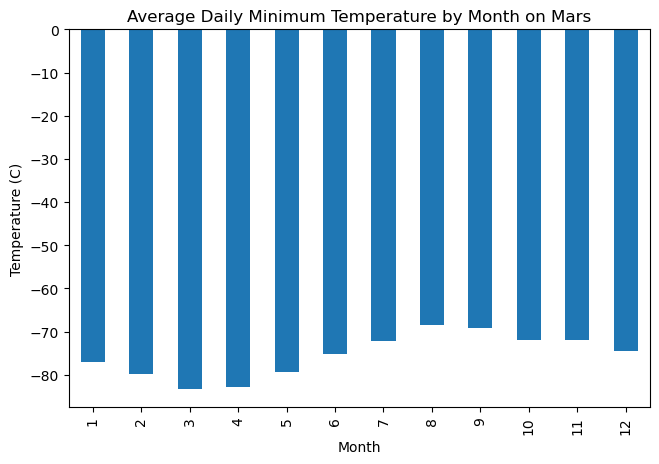

In [17]:
# Set global figure size and dpi
plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["figure.dpi"] = 100

# Plot the average temperature by month
df.groupby('month')['min_temp'].mean().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Temperature (C)')
plt.title('Average Daily Minimum Temperature by Month on Mars');

By visualization, the coldest month on Mars at the location of Curiosity is the third month, and the warmest is the eighth month.

In [18]:
# Alternatively, use built-in Pandas functions to identify the coldest and hottest months in Curiosity's location
print(f"The lowest daily temperature, on average, occurs in month {df.groupby('month')['min_temp'].mean().idxmin()}, "
      f"and the highest daily temperature, on average, occurs in month {df.groupby('month')['min_temp'].mean().idxmax()}.")

The lowest daily temperature, on average, occurs in month 3, and the highest daily temperature, on average, occurs in month 8.


In [19]:
# 4. Average pressure by Martian month
df.groupby('month')['pressure'].mean().round(2)

month
1     862.49
2     889.46
3     877.32
4     806.33
5     748.56
6     745.05
7     795.11
8     873.83
9     913.31
10    887.31
11    857.01
12    842.16
Name: pressure, dtype: float64

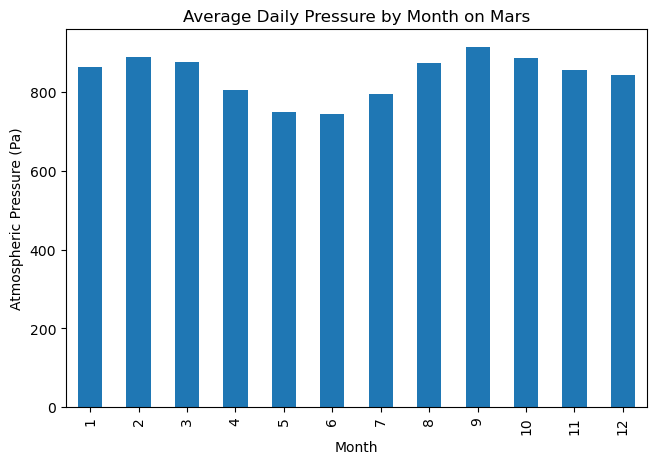

In [20]:
# Plot the average pressure by month
df.groupby('month')['pressure'].mean().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Atmospheric Pressure (Pa)')
plt.title('Average Daily Pressure by Month on Mars');

In [21]:
print(f"On average, the daily atmospheric pressure is lowest in month {df.groupby('month')['pressure'].mean().idxmin()} "
      f"and highest in month {df.groupby('month')['pressure'].mean().idxmax()}.")

On average, the daily atmospheric pressure is lowest in month 6 and highest in month 9.


There are approximately 686 earth days in a Martian year.


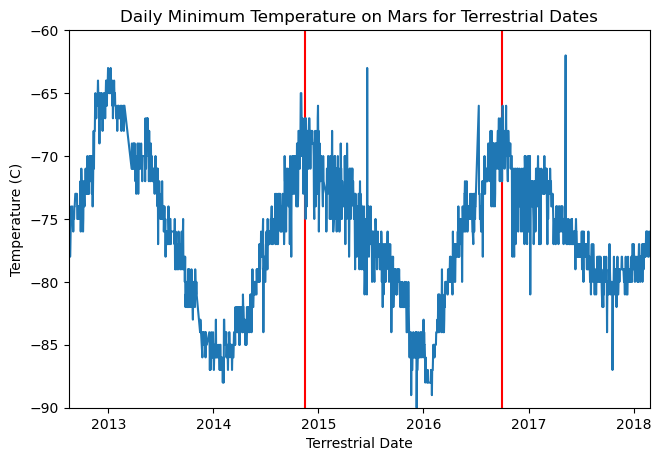

In [22]:
# 5. How many terrestrial (earth) days are there in a Martian year?
# Solution 1: Use the line plot of daily minimum temperature to visualize periodicity that indicates the period span of Martian
# year in terms of terrestrial days.
fig, ax = plt.subplots()
ax.plot(df.terrestrial_date, df.min_temp)
ax.set(xlabel='Terrestrial Date', ylabel='Temperature (C)',
       xlim=[df.terrestrial_date.iloc[0], df.terrestrial_date.iloc[-1]], ylim=[-90, -60],
       title='Daily Minimum Temperature on Mars for Terrestrial Dates')

# Try different start and end dates until they approximately match the two peaks in the line plot, as shown by the
# red andvertical lines intersect with the local peaks in temeprature.
start_date = dt.datetime(2014, 11, 15)
end_date = dt.datetime(2016, 10, 1)
ax.vlines(start_date, -90, -60, color='red')
ax.vlines(end_date, -90, -60, color='red')

# Subtract the dates to find how many earth days there are in a Martian year.
print(f'There are approximately {(end_date - start_date).days} earth days in a Martian year.')

In [23]:
# Solution 2
# As formerly mentioned, each row in the `martian_months` DataFrame corresponds to the first occurrence of a Martian month that
# is different from the Martian month of the previous row in the original DataFrame; as such, the `martian_months` DataFrame
# records the distinct months over the period of transmissions. Since there are also 12 months on Mars, the number of earth days
# between one distinct month on Mars (represented by one row in the `martian_months` DataFrame) and its next occurence
# (represented by the entry 12 rows from it) yields the number of earth days in a Martian year. Excluding the first row (which 
# could contain incomplete number of monthly sols), there exist 23 such row pairs and the number of earth days between each pair
# can be averaged to approximate the duration of a Martian year.

avg_earth_days = np.mean([(martian_months.iloc[i+12].terrestrial_date-martian_months.iloc[i].terrestrial_date).days 
                          for i in range(1, 24)])
print(f'There are approximately {avg_earth_days:.2f} earth days in a Martian year.')

There are approximately 687.22 earth days in a Martian year.


### Step 6: Save the Data

Export the DataFrame to a CSV file.

In [24]:
# Write the data to a CSV
df.to_csv("output/mars_weather.csv", index=False)

In [25]:
browser.quit()